### 8-6 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#모토사이클,야구,그래픽스,윈도우즈,중동,기독교,전자공학, 의학 8개 주제를 추출
cats=['rec.motorcycles','rec.sport.baseball','comp.graphics','comp.windows.x','talk.politics.mideast','soc.religion.christian','sci.electronics','sci.med']

#위에서 cats 변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats 입력
news_df=fetch_20newsgroups(subset='all',remove=('headers','footers','quotes'),categories=cats,random_state=0)

#LDA는 Count기반의 벡터화만 적용합니다.
count_vect=CountVectorizer(max_df=0.95,max_features=1000,min_df=2,stop_words='english',ngram_range=(1,2))
feat_vect=count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape : ',feat_vect.shape)

CountVectorizer Shape :  (7862, 1000)


In [3]:
lda=LatentDirichletAllocation(n_components=8,random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [4]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [7]:
#display_topics() -> 각 토픽별로 연관도가 높은 순으로 Word를 나열하는 기능
def display_topics(model,feature_names,no_top_words):
    for topic_index,topic in enumerate(model.components_):
        print("Topoc #",topic_index)
        
        #components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환.
        topic_word_indexes=topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        #top_indexes 대상인 인덱스별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat=' , '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        
#CountVectorizer 객체 내의 전체 word의 명칭을 get_feature_names()를 통해 추출
feature_names=count_vect.get_feature_names()

#토픽별 가장 연관도가 높은 Word를 15개만 추출
display_topics(lda,feature_names,15)

Topoc # 0
year , 10 , game , medical , health , team , 12 , 20 , disease , cancer , 1993 , games , years , patients , good
Topoc # 1
don , just , like , know , people , said , think , time , ve , didn , right , going , say , ll , way
Topoc # 2
image , file , jpeg , program , gif , images , output , format , files , color , entry , 00 , use , bit , 03
Topoc # 3
like , know , don , think , use , does , just , good , time , book , read , information , people , used , post
Topoc # 4
armenian , israel , armenians , jews , turkish , people , israeli , jewish , government , war , dos dos , turkey , arab , armenia , 000
Topoc # 5
edu , com , available , graphics , ftp , data , pub , motif , mail , widget , software , mit , information , version , sun
Topoc # 6
god , people , jesus , church , believe , christ , does , christian , say , think , christians , bible , faith , sin , life
Topoc # 7
use , dos , thanks , windows , using , window , does , display , help , like , problem , server , need 

### 8-7 문서 군집화 소개와 실습(Opinion Review 데이터 세트) 

```
- 문서 군집화(Document Clustering)의 개념 
    : 비슷한 텍스트 구성의 문서를 군집화(Clustering)하는 것.
    : 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류할 수 있음.
    
☆텍스트분류기반의 문서분류와 다른점
 - 앞서 배운 텍스트분류(ex. CountVectorizer...)는 사전에 결정 카테고리 값을 가진 지도학습!
 - 문서군집화는 비지도학습!!
 ```

In [8]:
#알아보려는 것 - 파일명별로 어떤 리뷰를 담고 있는지!!
import pandas as pd
import glob,os

path=r'C:\Users\ss\Desktop\kuggle 2기\winter_kuggle\8주차(~8.10)\OpinosisDataset1.0\OpinosisDataset1.0\topics'
#path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합.
all_files=glob.glob(os.path.join(path,"*.data"))
filename_list=[]
opinion_text=[]

#개별 파일의 파일명은 filename_list로 취합
#개별 파일의 파일 내용은 DataFrame으로 로딩 후 다시 string으로 변환해 opinoin_text list로 취합
for file_ in all_files:
    #개별 파일을 읽어서 DataFrame으로 생성
    df=pd.read_table(file_,index_col=None,header=0,encoding='latin1')
    
    #절대경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 다음 \\를 /로 변경.
    #맨 마지막 .data 확장자도 제거
    filename_=file_.split('\\')[-1]
    filename=filename_.split('.')[0]
    
    #파일명 list와 파일내용 list에 파일명과 파일 내용을 추가.
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
#파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df=pd.DataFrame({'filename':filename_list,'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc..."
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and..."
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2..."


In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\ss\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [11]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [12]:
document_df['cluster_label']=cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",2
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",0
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...,1
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...,1
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2...",1


In [13]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",0
32,room_holiday_inn_london,"We arrived at 23,30 hours and they could n...",0
30,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , Helpless...",0
31,rooms_swissotel_chicago,The Swissotel is one of our favorite hotel...,0


In [14]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...,1
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...,1
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2...",1
19,keyboard_netbook_1005ha,", I think the new keyboard rivals the gre...",1
26,performance_netbook_1005ha,The Eee Super Hybrid Engine utility lets u...,1
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,1
44,speed_windows7,"Windows 7 is quite simply faster, more sta...",1


In [15]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",2
5,buttons_amazon_kindle,I thought it would be fitting to christen ...,2
8,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken ...,2
9,display_garmin_nuvi_255W_gps,3 quot widescreen display was a ...,2
10,eyesight-issues_amazon_kindle,It feels as easy to read as the K1 but doe...,2
11,features_windows7,"I had to uninstall anti, virus and selecte...",2
12,fonts_amazon_kindle,Being able to change the font sizes is aw...,2
23,navigation_amazon_kindle,"In fact, the entire navigation structure h...",2
33,satellite_garmin_nuvi_255W_gps,It's fast to acquire satel...,2
34,screen_garmin_nuvi_255W_gps,It is easy to read and when touching the...,2


In [16]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
13,food_holiday_inn_london,The room was packed to capacity with queu...,3
14,food_swissotel_chicago,The food for our event was deli...,3
15,free_bestwestern_hotel_sfo,The wine reception is a great idea as it i...,3
20,location_bestwestern_hotel_sfo,"Good Value good location , ideal ...",3
21,location_holiday_inn_london,Great location for tube and we crammed in...,3
24,parking_bestwestern_hotel_sfo,Parking was expensive but I think this is ...,3
27,price_amazon_kindle,"If a case was included, as with the Kindle...",3
28,price_holiday_inn_london,"All in all, a normal chain hotel on a nice...",3
38,service_bestwestern_hotel_sfo,Both of us having worked in tourism for o...,3
39,service_holiday_inn_london,"not customer, oriented hotelvery low servi...",3


In [17]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,"Drivers seat not comfortable, the car its...",4
7,comfort_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,4
16,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,4
17,interior_honda_accord_2008,I love the new body style and the interior...,4
18,interior_toyota_camry_2007,"First of all, the interior has way too ma...",4
22,mileage_honda_accord_2008,"It's quiet, get good gas mileage and look...",4
25,performance_honda_accord_2008,"Very happy with my 08 Accord, performance i...",4
29,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which ...,4
37,seats_honda_accord_2008,Front seats are very uncomfor...,4
47,transmission_toyota_camry_2007,"After slowing down, transmission has to b...",4


```
(결과)
Cluster #0 - 호텔에 대한 리뷰
Cluster #1 - 킨들, 아이팟, 넷북 등의 포터블 전자기기에 대한 리뷰
Cluster #2 - 킨들, 아이팟, 넷북이 포함되어 있지만 주로 차량용 내비게이션에 대한 리뷰
Cluster #3 - 킨들 리뷰가 1개 있으며, 주로 호텔에 대한 리뷰
Cluster #4 - 토요타, 혼다 등 자동차에 대한 리뷰

(분석)
 - Cluser 0과 3의 내용이 겹칩
 - 포터블 전자기기와 차량용 내비게이션도 전자기기는 같은 전자기기니까 하나로 합쳐져도 괜찮을 것 같음
 
(결과에 대한 결론)
 - 군집을 5개에서 3개로 줄여보자!
 ```

In [18]:
from sklearn.cluster import KMeans

#3개의 집합으로 군집화
km_cluster=KMeans(n_clusters=3,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

#소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label']=cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",0
48,updates_garmin_nuvi_255W_gps,Another thing to consider was that I paid $...,0
44,speed_windows7,"Windows 7 is quite simply faster, more sta...",0
43,speed_garmin_nuvi_255W_gps,Another feature on the 255w is a display of...,0
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
41,size_asus_netbook_1005ha,A few other things I'd like to point out i...,0
36,screen_netbook_1005ha,Keep in mind that once you get in a room ...,0
35,screen_ipod_nano_8gb,"As always, the video screen is sharp and b...",0
34,screen_garmin_nuvi_255W_gps,It is easy to read and when touching the...,0
33,satellite_garmin_nuvi_255W_gps,It's fast to acquire satel...,0


#### 군집별 핵심단어 추출하기 

In [19]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 2409)
[[0.01819865 0.         0.         ... 0.         0.         0.00471073]
 [0.         0.00170335 0.0025537  ... 0.0032582  0.00349413 0.        ]
 [0.         0.00137309 0.         ... 0.         0.         0.        ]]


In [20]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details


In [21]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')


In [22]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'life', 'battery life', 'keyboard', 'kindle', 'size', 'button', 'easy', 'voice']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'location', 'staff', 'food', 'clean', 'bathroom', 'parking', 'room wa']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'location_bestwestern_hotel_sfo', 'location_holiday_inn_london', 'parking_bestwestern_hotel_sfo']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'car', 'gas', 'transmission', 'gas mileage', 'ride', 'comfort']
Reviews 파일명 : ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord

### 8-8 문서 유사도
#### 문장의 길이와 단어의 빈도를 동시에 고려!

In [23]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [25]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [26]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [29]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [30]:
#Opinion Review 데이터 세트를 이용한 문서 유사도 측정
#ln 8 ,9, 10 , 18과 코드가 겹치므로 이 부분은 입력한 것으로 간주하고 다음 코드 진행
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.05907195 0.05404862 0.03739629 0.06629355 0.06734556
  0.04017338 0.13113702 0.41011101 0.3871916  0.57253197 0.10600704
  0.13058128 0.1602411  0.05539602 0.05839754]]


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

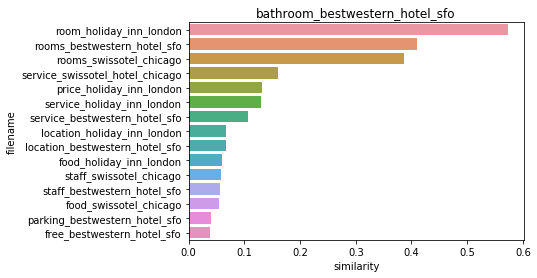

In [31]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

-------------------------------------------------------------------------------------------------------------------------